## Imports & Settings

In [88]:
from time import time
import warnings
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.decomposition import IncrementalPCA

In [31]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [3]:
analogies_path = Path('data', 'analogies', 'analogies-en.txt')

## Convert GloVE Vectors to gensim format

The various GloVE vectors are available [here](https://nlp.stanford.edu/projects/glove/). Download link for the [wikipedia](http://nlp.stanford.edu/data/glove.6B.zip) version. Unzip and store in `data/glove`.

### WikiPedia

In [4]:
glove_path = Path('data/glove')
glove_wiki_file= glove_path / 'glove.6B.300d.txt'
word2vec_wiki_file = glove_path / 'glove.wiki.gensim.txt'

In [5]:
glove2word2vec(glove_input_file=glove_wiki_file, word2vec_output_file=word2vec_wiki_file)

(400001, 300)

### Twitter Data

In [6]:
glove_twitter_file= glove_path / 'glove.twitter.27B.200d.txt'
word2vec_twitter_file = glove_path / 'glove.twitter.gensim.txt'

In [7]:
glove2word2vec(glove_input_file=glove_twitter_file, word2vec_output_file=word2vec_twitter_file)

(1193517, 200)

### Common Crawl

In [8]:
glove_crawl_file= glove_path / 'glove.840B.300d.txt'
word2vec_crawl_file = glove_path / 'glove.crawl.gensim.txt'

In [9]:
glove2word2vec(glove_input_file=glove_crawl_file, word2vec_output_file=word2vec_crawl_file)

(2196018, 300)

## Evaluate embeddings

In [10]:
def eval_analogies(file_name, vocab=30000):
    model = KeyedVectors.load_word2vec_format(file_name, binary=False)
    accuracy = model.wv.accuracy(analogies_path,
                                 restrict_vocab=vocab,
                                 case_insensitive=True)
    return (pd.DataFrame([[c['section'],
                           len(c['correct']),
                           len(c['incorrect'])] for c in accuracy],
                         columns=['category', 'correct', 'incorrect'])
            .assign(samples=lambda x: x.correct.add(x.incorrect))
            .assign(average=lambda x: x.correct.div(x.samples))
            .drop(['correct', 'incorrect'], axis=1))

In [11]:
result = eval_analogies(word2vec_twitter_file, vocab=100000)

### twitter result

In [12]:
twitter_result = eval_analogies(word2vec_twitter_file, vocab=100000)
twitter_result.to_csv(glove_path / 'accuracy_twitter.csv', index=False)
twitter_result

,category,samples,average
0,capital-common-countries,462,0.701299
1,capital-world,930,0.690323
2,city-in-state,3644,0.350714
3,currency,268,0.018657
4,family,342,0.824561
5,gram1-adjective-to-adverb,650,0.143077
6,gram2-opposite,342,0.365497
7,gram3-comparative,1260,0.757937
8,gram4-superlative,930,0.686022
9,gram5-present-participle,702,0.750712


### wiki result

In [19]:
wiki_result = eval_analogies(word2vec_wiki_file, vocab=100000)
wiki_result.to_csv(glove_path / 'accuracy_wiki.csv', index=False)
wiki_result

,category,samples,average
0,capital-common-countries,506,0.948617
1,capital-world,8372,0.964644
2,city-in-state,4242,0.599953
3,currency,752,0.174202
4,family,506,0.881423
5,gram1-adjective-to-adverb,992,0.225806
6,gram2-opposite,756,0.285714
7,gram3-comparative,1332,0.882132
8,gram4-superlative,1056,0.746212
9,gram5-present-participle,1056,0.699811


### Common Crawl result

In [30]:
crawl_result = eval_analogies(word2vec_crawl_file, vocab=100000)
crawl_result.to_csv(glove_path / 'accuracy_crawl.csv', index=False)
crawl_result

,category,samples,average
0,capital-common-countries,506,0.946640
1,capital-world,4290,0.917483
2,city-in-state,4242,0.706742
3,currency,206,0.184466
4,family,420,0.978571
5,gram1-adjective-to-adverb,992,0.388105
6,gram2-opposite,702,0.363248
7,gram3-comparative,1332,0.876877
8,gram4-superlative,1122,0.919786
9,gram5-present-participle,1056,0.827652


### Combine & compare results

In [47]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [46]:
accuracy = (twitter_result.assign(glove='Twitter')
            .append(wiki_result.assign(glove='Wiki'))
            .append(crawl_result.assign(glove='Crawl')))

In [48]:
accuracy.category=accuracy.category.replace(cat_dict)
accuracy = accuracy.rename(columns=str.capitalize)

In [74]:
accuracy.to_csv(glove_path / 'accuracy.csv', index=False)

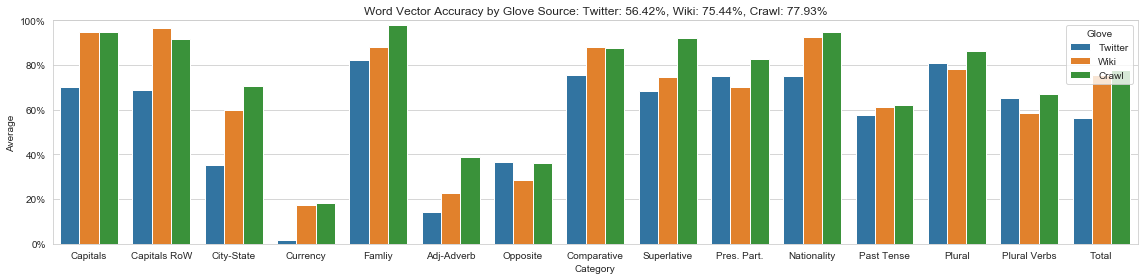

In [73]:
fig, ax = plt.subplots(figsize=(16, 4))
sns.barplot(x='Category', y='Average', hue='Glove', data=accuracy, ax=ax)
ax.set_title(f'Word Vector Accuracy by Glove Source: Twitter: {0.564228:.2%}, Wiki: {0.75444:.2%}, Crawl: {0.779347:.2%}')
ax.set_ylim(0,1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
fig.tight_layout()
fig.savefig('figures/glove_accuracy', dpi=300);

## Visualize Embeddings

### Load GloVe Wiki Vectors

In [75]:
model = KeyedVectors.load_word2vec_format(word2vec_wiki_file, binary=False)

In [87]:
accuracy = model.accuracy(questions=str(analogies_path), restrict_vocab=100000)

In [78]:
vectors = model.vectors[:100000]
vectors /= norm(vectors, axis=1).reshape(-1, 1)
vectors.shape

(100000, 300)

In [79]:
words = model.index2word[:100000]
word2id = {w:i for i, w in enumerate(words)}

### Project Embedding into 2D

In [82]:
pca = IncrementalPCA(n_components=2)

vectors2D = pca.fit_transform(vectors)
pd.Series(pca.explained_variance_ratio_).mul(100)

0    2.604632
1    1.293813
dtype: float64

### Plot Analogy Examples

In [89]:
results = pd.DataFrame()
correct = incorrect = 0
for section in accuracy:
    correct += len(section['correct'])
    incorrect += len(section['incorrect'])
    df = pd.DataFrame(section['correct']).apply(lambda x: x.str.lower()).assign(section=section['section'])
    results = pd.concat([results, df])

In [90]:
def find_most_similar_analogy(v):
    """Find analogy that most similar in 2D"""
    v1 = vectors2D[v[1]] - vectors2D[v[0]]
    v2 = vectors2D[v[3]] - vectors2D[v[2]]
    idx, most_similar = None, np.inf
    
    for i in range(len(v1)):
        similarity = cosine(v1[i], v2[i])
        if similarity < most_similar:
            idx = i
            most_similar = similarity
    return idx

In [91]:
def get_plot_lims(coordinates):
    xlim, ylim = coordinates.agg(['min', 'max']).T.values
    xrange, yrange = (xlim[1] - xlim[0]) * .1, (ylim[1] - ylim[0]) * .1
    xlim[0], xlim[1] = xlim[0] - xrange, xlim[1] + xrange
    ylim[0], ylim[1] = ylim[0] - yrange, ylim[1] + yrange
    return xlim, ylim

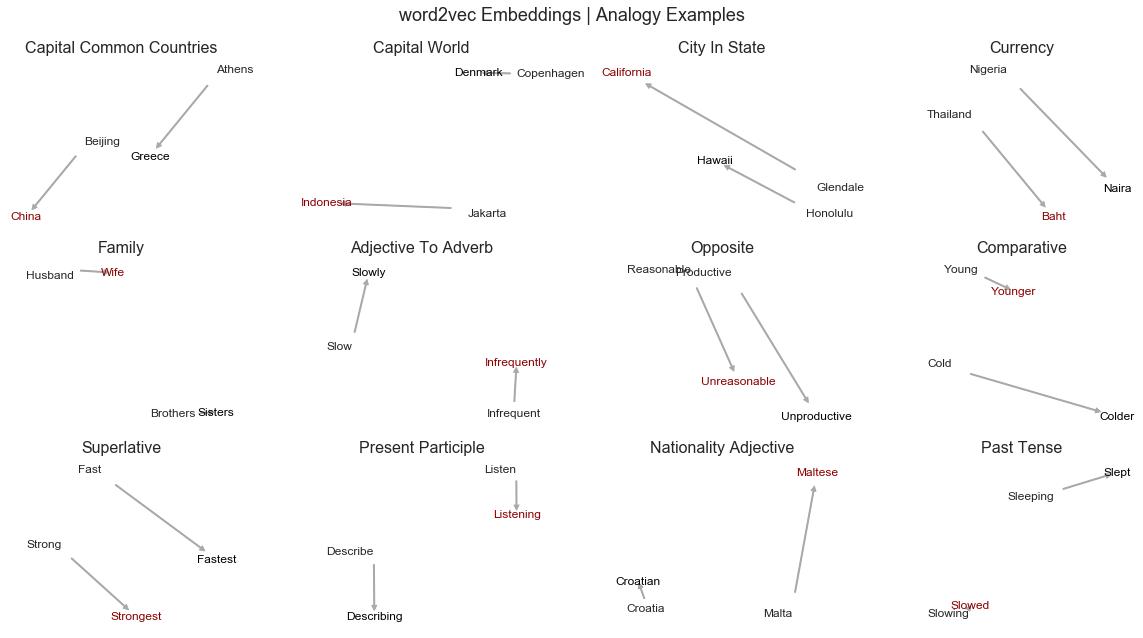

In [98]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flatten()
fc = ec = 'darkgrey'
for s, (section, result) in enumerate(results.groupby('section')):
    if s > 11:
        break
        
    df = result.drop('section', axis=1).apply(lambda x: x.map(word2id))
    most_similar_idx = find_most_similar_analogy(df)
    
    best_analogy = result.iloc[most_similar_idx, :4].tolist()

    analogy_idx = [words.index(word) for word in best_analogy]
    best_analogy = [a.capitalize() for a in best_analogy]
    
    coords = pd.DataFrame(vectors2D[analogy_idx])  # xy array
    
    xlim, ylim = get_plot_lims(coords)
    axes[s].set_xlim(xlim)
    axes[s].set_ylim(ylim)

    for i in [0, 2]:
        axes[s].annotate(s=best_analogy[i], xy=coords.iloc[i+1], xytext=coords.iloc[i],
                         arrowprops=dict(width=1,headwidth=5, headlength=5,
                                         fc=fc, ec=ec, shrink=.1),
                         fontsize=12)
    
        axes[s].annotate(best_analogy[i+1], xy=coords.iloc[i+1],
                         xytext=coords.iloc[i+1],
                         va='center', ha='center',
                         fontsize=12, color='darkred' if i == 2 else 'k');

    axes[s].axis('off')
    title = ' '.join([s.capitalize()
                      for s in section.split('-') if not s.startswith('gram')])
    axes[s].set_title(title, fontsize=16)

fig.suptitle('word2vec Embeddings | Analogy Examples', fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/w2v_analogies', dpi=300);